In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model_path = './'

model = AutoModelForCausalLM.from_pretrained(
    model_path, 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_path)


In [ ]:

messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"},
    {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
    {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])


### Data processing ###
- Load model with tokenizer
- Define data processing function

In [ ]:
from datasets import load_dataset

checkpoint_path = "./"
model_kwargs = dict(
    use_cache=False,
    trust_remote_code=True,
    attn_implementation="flash_attention_2",  # loading the model with flash-attenstion support
    torch_dtype=torch.bfloat16,
    device_map=None
)

model = AutoModelForCausalLM.from_pretrained(checkpoint_path, **model_kwargs)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
tokenizer.model_max_length = 2048
tokenizer.pad_token = tokenizer.unk_token  # use unk rather than eos token to prevent endless generation
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
tokenizer.padding_side = 'right'



In [ ]:

def apply_chat_template(
    example,
    tokenizer,
):
    messages = example["messages"]
    example["text"] = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False)
    return example

raw_dataset = load_dataset("./dataset/data")
train_dataset = raw_dataset["train"]
test_dataset = raw_dataset["test"]
# train_dataset = raw_dataset["train_sft"]
# test_dataset = raw_dataset["test_sft"]
column_names = list(train_dataset.features)

processed_train_dataset = train_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer},
    num_proc=1,
    remove_columns=column_names,
    desc="Applying chat template to train_sft",
)

processed_test_dataset = test_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer},
    num_proc=1,
    remove_columns=column_names,
    desc="Applying chat template to test_sft",
)


### We try to visualize the data here for all kinds of the sgy files
- All NZ data

In [ ]:
import segyio
import numpy as np


def ReadSEGYData(filename):
    print("### Reading SEGY-formatted Seismic Data:")
    print("Data file-->[%s]" % (filename))

    with segyio.open(filename, "r", ignore_geometry=True) as f:
        f.mmap()
        nTrace = f.tracecount
        nSample = f.bin[segyio.BinField.Samples]
        startT = 0
        deltaT = f.bin[segyio.BinField.Interval]
        inlines = f.attributes(segyio.TraceField.INLINE_3D)[:]
        xlines = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]
        
        # Determine the range and sampling rate of inlines and xlines
        inline_range = (min(inlines), max(inlines))
        xline_range = (min(xlines), max(xlines))
        
        inline_sampling_rate = (inline_range[1] - inline_range[0]) / (len(set(inlines)) - 1)
        xline_sampling_rate = (xline_range[1] - xline_range[0]) / (len(set(xlines)) - 1)

        print("     Inline Range          = %s" % (str(inline_range)))
        print("     Xline Range           = %s" % (str(xline_range)))
        print("     Number of Traces      = %d" % (nTrace))
        print("     Number of Samples     = %d" % (nSample))
        print("     Start Sample          = %d" % (startT))
        print("     Sampling Rate (Time)  = %d µs" % (deltaT))
        print("     Inline Sampling Rate  = %f" % (inline_sampling_rate))
        print("     Crossline Sampling Rate = %f" % (xline_sampling_rate))

        # Read inline and crossline (xline) numbers
        data2D = np.asarray([np.copy(x) for x in f.trace[:]]).T
    my_data = [data2D, nTrace, nSample, startT, deltaT, inline_sampling_rate, xline_sampling_rate]
    f.close()
    return my_data


# 加载文件夹数据
# data2D = r"F:\Facies\FaciesData\KAHU-3D-PR3177-FM.3D.Final_Migration.sgy"
# data2D = r"F:\Facies\FaciesData\3D-Waihapa.sgy"
# data2D = r"F:\Facies\FaciesData\3D-Waipuku.sgy"
# data2D = r"F:\Facies\FaciesData\Kerry3D.segy"
# data2D = r"F:\Facies\FaciesData\Parihaka_PSTM_full_angle.sgy"
# data2D = r"D:\Pycharm Projects\1_Original_Seismics.sgy"
# Specify the path to your SEGY file
segy_file_path = '/home/dell/disk1/Jinlong/NCdata/3D-Waipuku.sgy'


"""parihaka new zealand we use in facies : Inline Range= (1735, 2657) Xline Range = (4200, 5325) sampling rate: """
my_data = ReadSEGYData(segy_file_path)

### Unzip all the files in the folder

In [5]:
import os
import tarfile

# Specify the directory to search for .tar.gz files
search_directory = '/home/dell/disk1/Jinlong/NCdata/elastic-marmousi-model/processed_data/SEGY-Time'

for file in os.listdir(search_directory):
    if file.endswith('.tar.gz'):

        file_path = os.path.join(search_directory, file)
        # extract_path = os.path.join(search_directory, os.path.splitext(file)[0])
        extract_path = os.path.join(search_directory, file[:-7])  
        os.makedirs(extract_path, exist_ok=True)
        
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=extract_path)
            print(f"Extracted {file} to {extract_path}")
            os.remove(file_path)
            
        # List the extracted files
        extracted_files = os.listdir(extract_path)
        for extracted_file in extracted_files:
            print(f"  - {os.path.join(extract_path, extracted_file)}")

### Save segy files into npy files

- This code will save the sgy or segy file with their corresponding names in npy format.

In [10]:
import segyio
import numpy as np
import os

def segy_to_npy(segy_file, output_dir):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with segyio.open(segy_file, 'r', ignore_geometry=True) as segy:
        file_name = os.path.basename(segy_file)
        file_name = os.path.splitext(file_name)[0]

        traces = segy.trace.raw[:]
        print(traces.shape)
        np.save(os.path.join(output_dir, f'{file_name}.npy'), traces)


# Search the folders if there exists the segy files. The folder can not only be the lowest level folder
def find_segy_files(folder_path):
        
    # List to store found SEGY/SGY files
    segy_files = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.segy') or file.endswith('.sgy'):
                # Get the full path of the file
                full_path = os.path.join(root, file)
                segy_files.append(full_path)
    if segy_files:
        print("Found SEGY/SGY files:")
        for segy_file in segy_files:
            print(segy_file)
    else:
        print("No SEGY/SGY files found.")
    
    return segy_files

# segy_file = '/home/dell/disk1/Jinlong/NCdata/3D-Waipuku.sgy'
# segy_file = '/home/dell/disk1/Jinlong/NCdata/Kerry3D.segy'

output_dir = './saved_npy_files'
folder_path = '/home/dell/disk1/Jinlong/NCdata/SEAM_Interpretation_Challenge_1_Depth'

segy_file = find_segy_files(folder_path)

for file in segy_file:
    segy_to_npy(file, output_dir)
    # pass


Found SEGY/SGY files:
/home/dell/disk1/Jinlong/NCdata/SEAM_Interpretation_Challenge_1_Depth/SEAM_Interpretation_Challenge_1_Depth.sgy
/home/dell/disk1/Jinlong/NCdata/SEAM_Interpretation_Challenge_1_Depth/SEAM_Interpretation_Challenge_1_2DGathers_Depth.sgy
/home/dell/disk1/Jinlong/NCdata/SEAM_Interpretation_Challenge_1_Depth/SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy
(1171338, 751)
(30000, 751)
(990, 751)


### After we save the segy for sgy files into npy format we can examine them with the plot.

- For 2D

Data shape: (69235, 2501)


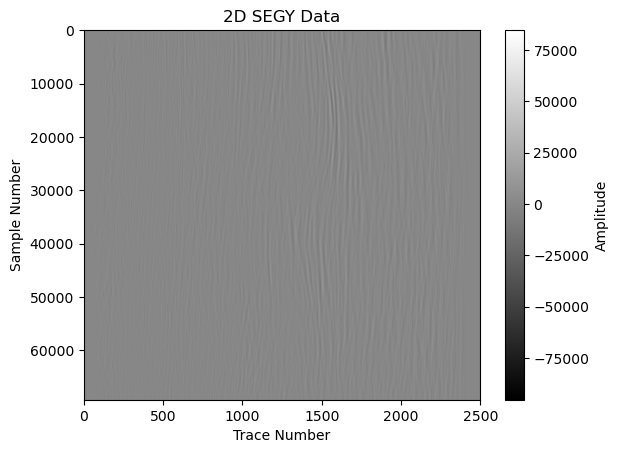

In [38]:
import matplotlib.pyplot as plt
import random

seismic_files = np.load('/home/dell/disk1/Jinlong/Seismic-phi3/KAHU-3D-PR3177-FM.3D.Final_Migration.npy')

print(f"Data shape: {seismic_files.shape}")

random.seed(42)

# slice_indice = random.randint(0, seismic_files.shape[1])
# print(seismic_files[slice_indice].shape)
# Optionally, plot a slice of the data

plt.imshow(seismic_files, aspect='auto', cmap='gray')
plt.title('2D SEGY Data')
plt.xlabel('Trace Number')
plt.ylabel('Sample Number')
plt.colorbar(label='Amplitude')
plt.show()



- For 3D

In [ ]:
import matplotlib.pyplot as plt
import random

seismic_files = np.load('/home/dell/disk1/Jinlong/Seismic-phi3/3D-Waipuku.npy')

print(f"Data shape: {seismic_files.shape}")

random.seed(42)

# slice_indice = random.randint(0, seismic_files.shape[1])
# print(seismic_files[slice_indice].shape)
# Optionally, plot a slice of the data
plt.imshow(seismic_files, aspect='auto', cmap='gray')
plt.title('2D SEGY Data')
plt.xlabel('Trace Number')
plt.ylabel('Sample Number')
plt.colorbar(label='Amplitude')
plt.show()

